# **1. Configuración del ambiente**

In [1]:
from typing import Final
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
DATA_DIR: Final = os.path.join(
    os.getcwd(),
    'data',
    'ml-latest-small'
)
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  955k    1 13443    0     0  33813      0  0:00:28 --:--:--  0:00:28 34032
 29  955k   29  283k    0     0   190k      0  0:00:05  0:00:01  0:00:04  190k
 62  955k   62  594k    0     0   247k      0  0:00:03  0:00:02  0:00:01  248k
100  955k  100  955k    0     0   273k      0  0:00:03  0:00:03 --:--:--  273k
100  955k  100  955k    0     0   273k      0  0:00:03  0:00:03 --:--:--  273k


# **2. Obtención de datos**

In [2]:
dir_movies = os.path.join(DATA_DIR, 'movies.csv')
df_movies = pd.read_csv(dir_movies)
dir_ratings = os.path.join(DATA_DIR, 'ratings.csv')
df_ratings = pd.read_csv(dir_ratings)

In [3]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
df_movies.shape

(9742, 3)

In [6]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
df_ratings.shape

(100836, 4)

# **3. Tratamiento de los datos**

## Datos nulos

In [9]:
df_movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [10]:
df_ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
def preprocesamiento():
    global df_movies, df_ratings
    df_movies.dropna(inplace=True)
    df_ratings.dropna(inplace=True)
    df_movies.drop_duplicates(subset='movieId',keep='first', inplace=True)
    df_ratings.drop_duplicates(subset=['movieId','userId'],keep='first', inplace=True)
    df_movies['content'] = df_movies['genres'].str.replace('|', ' ')
    df_movies['genre_set'] = df_movies['genres'].apply(
        lambda x: ', '.join(sorted(set(x.split('|'))))
    )
    df_ratings['timestamp'] = pd.to_datetime(
        df_ratings['timestamp'], unit='s'
    ).dt.normalize()

In [12]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None
-------------


# **4. Análisis Exploratorio (EDA)**

In [13]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB


In [14]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [15]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [16]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 03:54:37.829346560
min,1.00,1.00,0.50,1996-03-29 00:00:00
25%,177.00,1199.00,3.00,2002-04-18 00:00:00
50%,325.00,2991.00,3.50,2007-08-02 00:00:00
75%,477.00,8122.00,4.00,2015-07-04 00:00:00
max,610.00,193609.00,5.00,2018-09-24 00:00:00
std,182.62,35530.99,1.04,NaN


### Histograma de Ratings

Creamos un histograma para ver las distribución de las calificaciones que han dado los usuarios a las películas.

In [17]:
# Vemos el total de calificaciones por cada puntuación
df_ratings['rating'].value_counts()

rating
4.00    26818
3.00    20047
5.00    13211
3.50    13136
4.50     8551
2.00     7551
2.50     5550
1.00     2811
1.50     1791
0.50     1370
Name: count, dtype: int64

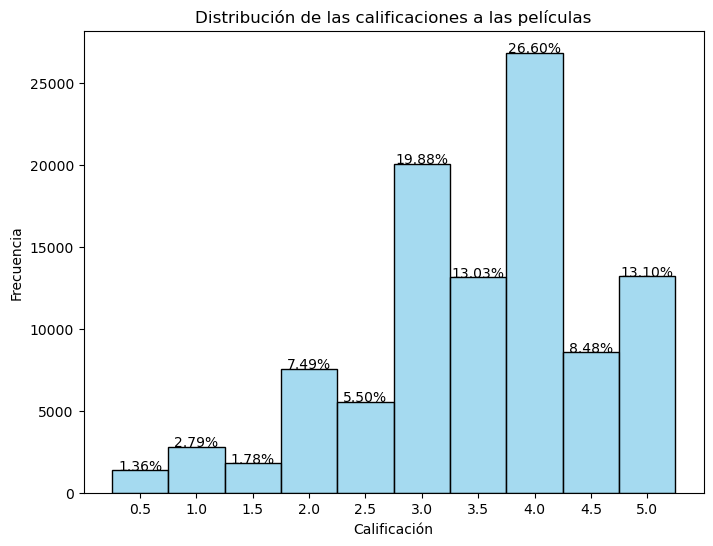

In [18]:
plt.figure(figsize=(8, 6))
bin_edges = np.arange(0.25, 5.75, 0.5)
# Creamos el histograma
ax = sns.histplot(df_ratings['rating'], bins=bin_edges, kde=False, color='skyblue', edgecolor='black')

# Calculamos el número total de calificaciones
total_ratings = df_ratings['rating'].count()

# Agregamos el porcentaje a cada barra
for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height / total_ratings) * 100:.2f}%'  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

# Creamos las etiquetas para cada valor de calificación
ax.set_xticks(np.arange(0.5, 5.5, 0.5))

# Agregamos encabezados al titulo y a los ejes
plt.title('Distribución de las calificaciones a las películas')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')

# Show plot
plt.show()


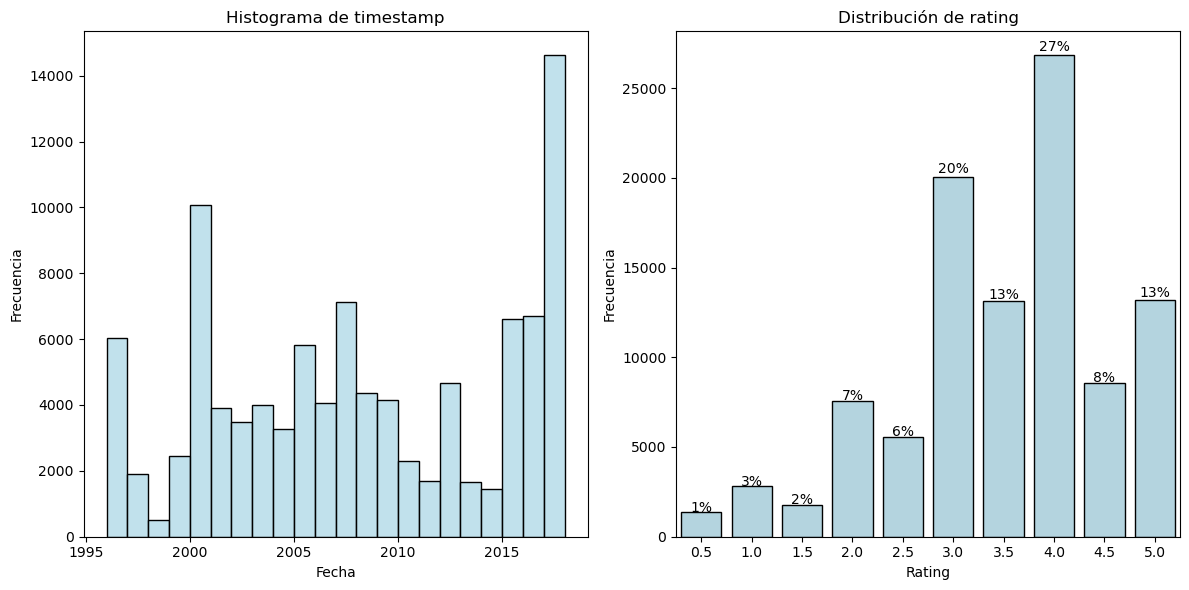

In [19]:
def timestamp_rating_graph():

    df_ratings['year'] = df_ratings['timestamp'].dt.year

    fig, (timestamp, rating) = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(
        data = df_ratings, x='year', kde=False,
        ax = timestamp, color = "lightblue", binwidth=1
    )

    sns.countplot(
        x = df_ratings['rating'], color = "lightblue",
        edgecolor = "black", ax = rating
    )

    total = len(df_ratings['rating'])
    for p in rating.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.0f}%'
        rating.text(
            p.get_x() + p.get_width() / 2,
            height + height * 0.01, percentage, ha="center"
        )

    timestamp.set_title('Histograma de timestamp')
    timestamp.set_xlabel('Fecha')
    timestamp.set_ylabel('Frecuencia')

    rating.set_title('Distribución de rating')
    rating.set_xlabel('Rating')
    rating.set_ylabel('Frecuencia')

    plt.tight_layout()

    return plt

timestamp_rating_graph().show()

### Histograma de calificaciones por año
Para entender como han calificado los usuarios a las películas a traves de los años , primero veremos las distribuciones totales de las calificaciones

Para entender mejor el histograma agruparemos las calificaciones entre 1 y 5 sin considerar los números flotantes

In [20]:
df_ratings['rating'].value_counts()

rating
4.00    26818
3.00    20047
5.00    13211
3.50    13136
4.50     8551
2.00     7551
2.50     5550
1.00     2811
1.50     1791
0.50     1370
Name: count, dtype: int64

In [21]:
# Creamos una función para categorizar
def categorizar_rating(rating):
    if rating <= 1.5:
        return 1
    elif rating <= 2.5:
        return 2
    elif rating <= 3.5:
        return 3
    elif rating <= 4.5:
        return 4
    else:
        return 5

In [22]:
# Ahora lo aplicamos a la columna rating
df_ratings['rating_categoria'] = df_ratings['rating'].apply(categorizar_rating)
df_ratings.head(5)

,userId,movieId,rating,timestamp,year,rating_categoria
0,1,1,4.00,2000-07-30,2000,4
1,1,3,4.00,2000-07-30,2000,4
2,1,6,4.00,2000-07-30,2000,4
3,1,47,5.00,2000-07-30,2000,5
4,1,50,5.00,2000-07-30,2000,5


In [23]:
df_ratings['rating_categoria'].value_counts()

rating_categoria
4    35369
3    33183
5    13211
2    13101
1     5972
Name: count, dtype: int64

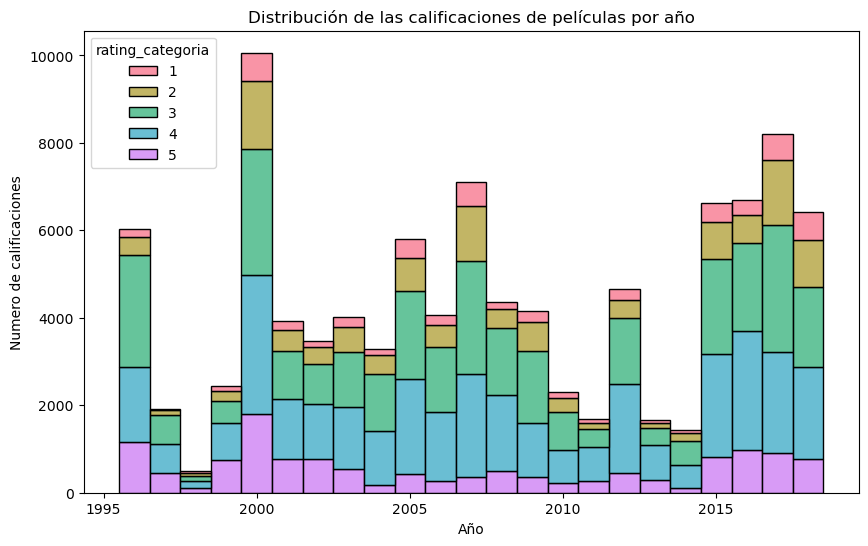

In [24]:
# Extraemos el año desde la columna timestamp
df_ratings['year'] = pd.to_datetime(df_ratings['timestamp']).dt.year
# Elegimos el color de la paleta a usar
colors = sns.color_palette("husl", 5)
# Creamos el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings, x='year', hue='rating_categoria', multiple='stack', bins=20,palette=colors, discrete=True)
plt.title('Distribución de las calificaciones de películas por año')
plt.xlabel('Año')
plt.ylabel('Numero de calificaciones')
plt.show()

### Gráfico de barras de popularidad de generos basada en las calificaciones
Para mostrar la popularidad de cada genero entre los usuarios basado en el número de calificaciones.

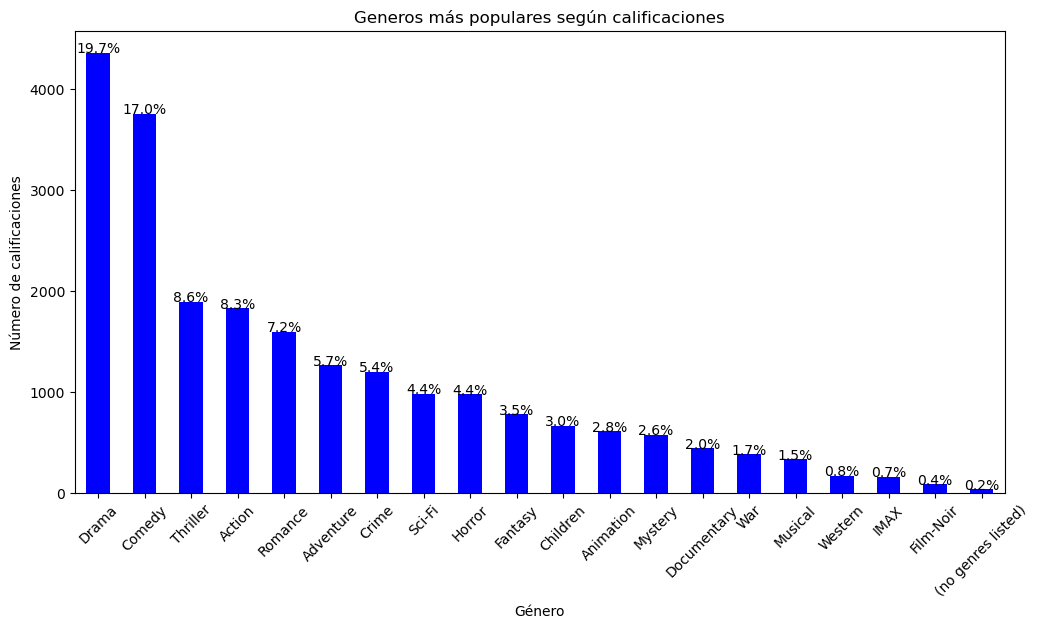

In [25]:
genre_counts = df_movies['genre_set'].str.get_dummies(', ').sum().sort_values(ascending=False)
total_ratings = genre_counts.sum()
genre_percentages = (genre_counts / total_ratings) * 100

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = genre_counts.plot(kind='bar', color='blue')

# Annotate each bar with the percentage
for i in range(len(genre_counts)):
    plt.text(i, genre_counts[i] + 0.4, f'{genre_percentages[i]:.1f}%', ha='center')

# Title and labels
plt.title('Generos más populares según calificaciones')
plt.xlabel('Género')
plt.ylabel('Número de calificaciones')
plt.xticks(rotation=45)
plt.show()

### Creamos el df_final uniendo los dos datasets:


In [26]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final.head(5)

,userId,movieId,rating,timestamp,year,rating_categoria,title,genres,content,genre_set
0,1,1,4.00,2000-07-30,2000,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
1,1,3,4.00,2000-07-30,2000,4,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"Comedy, Romance"
2,1,6,4.00,2000-07-30,2000,4,Heat (1995),Action|Crime|Thriller,Action Crime Thriller,"Action, Crime, Thriller"
3,1,47,5.00,2000-07-30,2000,5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Mystery Thriller,"Mystery, Thriller"
4,1,50,5.00,2000-07-30,2000,5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,Crime Mystery Thriller,"Crime, Mystery, Thriller"


In [27]:
df_final.shape

(100836, 10)

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userId            100836 non-null  int64         
 1   movieId           100836 non-null  int64         
 2   rating            100836 non-null  float64       
 3   timestamp         100836 non-null  datetime64[ns]
 4   year              100836 non-null  int32         
 5   rating_categoria  100836 non-null  int64         
 6   title             100836 non-null  object        
 7   genres            100836 non-null  object        
 8   content           100836 non-null  object        
 9   genre_set         100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(4)
memory usage: 7.3+ MB


# **5. Recomendación no personalizada**





In [29]:
def top_ten_popular_movies(df):
    # Group by movieId and title, then count the number of ratings for each movie
    movie_popularity = df.groupby(['movieId', 'title']).size().reset_index(name='rating_count')

    # Sort the movies by rating_count in descending order
    top_movies = movie_popularity.sort_values(by='rating_count', ascending=False).head(10)

    return top_movies

# Call the function and store the result
top_ten_movies = top_ten_popular_movies(df_final)

# Display the result
print(top_ten_movies)


      movieId                                      title  rating_count
314       356                        Forrest Gump (1994)           329
277       318           Shawshank Redemption, The (1994)           317
257       296                        Pulp Fiction (1994)           307
510       593           Silence of the Lambs, The (1991)           279
1938     2571                         Matrix, The (1999)           278
224       260  Star Wars: Episode IV - A New Hope (1977)           251
418       480                       Jurassic Park (1993)           238
97        110                          Braveheart (1995)           237
507       589          Terminator 2: Judgment Day (1991)           224
461       527                    Schindler's List (1993)           220


In [30]:
count_rating = df_final.title.value_counts()
df_final['count'] = df_final['title'].map(count_rating)
df_popular_movies = df_final[df_final['count'] > 210]
df_popular_movies.head(5)

,userId,movieId,rating,timestamp,year,rating_categoria,title,genres,content,genre_set,count
0,1,1,4.00,2000-07-30,2000,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy",215
7,1,110,4.00,2000-07-30,2000,4,Braveheart (1995),Action|Drama|War,Action Drama War,"Action, Drama, War",237
15,1,260,5.00,2000-07-30,2000,5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,Action Adventure Sci-Fi,"Action, Adventure, Sci-Fi",251
16,1,296,3.00,2000-07-30,2000,3,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Comedy Crime Drama Thriller,"Comedy, Crime, Drama, Thriller",307
20,1,356,4.00,2000-07-30,2000,4,Forrest Gump (1994),Comedy|Drama|Romance|War,Comedy Drama Romance War,"Comedy, Drama, Romance, War",329


In [31]:
df_movie_stats = df_popular_movies.groupby('title').agg(
    mean_rating=('rating', 'mean'),
    vote_count=('rating', 'size')
)

In [32]:
df_top_10_movies_count = df_movie_stats.sort_values(by='vote_count', ascending=False).head(10)
df_top_10_movies_count

,mean_rating,vote_count
title,,
Forrest Gump (1994),4.16,329
"Shawshank Redemption, The (1994)",4.43,317
Pulp Fiction (1994),4.20,307
"Silence of the Lambs, The (1991)",4.16,279
"Matrix, The (1999)",4.19,278
Star Wars: Episode IV - A New Hope (1977),4.23,251
Jurassic Park (1993),3.75,238
Braveheart (1995),4.03,237
Terminator 2: Judgment Day (1991),3.97,224


In [33]:
df_top_10_movies_rating = df_movie_stats.sort_values(by='mean_rating', ascending=False).head(10)
df_top_10_movies_rating

,mean_rating,vote_count
title,,
"Shawshank Redemption, The (1994)",4.43,317
Fight Club (1999),4.27,218
Star Wars: Episode IV - A New Hope (1977),4.23,251
Schindler's List (1993),4.22,220
Star Wars: Episode V - The Empire Strikes Back (1980),4.22,211
Pulp Fiction (1994),4.20,307
"Matrix, The (1999)",4.19,278
Forrest Gump (1994),4.16,329
"Silence of the Lambs, The (1991)",4.16,279
